In [1]:
# Data Science Project
# Caroline Forsythe, Julia Lapucha, Astghik Sarukhanyan
# 01.07.2024

In [2]:
# import libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
#from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

In [3]:
rna_data = pd.read_csv('Documents/ML/sig_DEG_counts_37samples.csv', index_col = 0)
meth_data = pd.read_csv('Documents/ML/transposedMethylationCounts.csv', index_col = 0)
labels = pd.read_csv('Documents/ML/sample_labels.csv', header = None)

In [4]:
#  filter samples , order correctly, rename esn numbers and concat cols
# intersection of indices, patients with both data
common_indices = meth_data.index.intersection(rna_data.index)
#print(common_indices)

# reindex methylation data
meth_new = meth_data.loc[common_indices]


# check that patient datasets now match
if (rna_data.index == meth_new.index).all()== True:
    rna_data.columns = [str(col) + '_rna' for col in rna_data.columns]
    meth_new.columns = [str(col) + '_meth' for col in meth_new.columns]
    conc_df = pd.concat([rna_data, meth_new], axis=1)
    conc_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, N_0026 to W_058
Columns: 127 entries, ENSG00000040531_rna to ENSG00000292423_meth
dtypes: int64(127)
memory usage: 38.0+ KB


In [5]:
conc_df.head()

,ENSG00000040531_rna,ENSG00000066230_rna,ENSG00000077157_rna,ENSG00000092098_rna,ENSG00000099901_rna,ENSG00000100242_rna,ENSG00000102904_rna,ENSG00000103260_rna,ENSG00000104872_rna,ENSG00000104886_rna,...,ENSG00000240160_meth,ENSG00000241241_meth,ENSG00000244130_meth,ENSG00000250397_meth,ENSG00000275969_meth,ENSG00000276040_meth,ENSG00000286919_meth,ENSG00000289708_meth,ENSG00000289901_meth,ENSG00000292423_meth
N_0026,499,653,150,294,209,1028,653,50,68,114,...,77,0,6,81,10,5,1,14,10,45
N_0035,172,505,104,214,198,451,565,7,50,105,...,84,5,6,80,17,10,1,17,9,31
N_0036,461,575,182,390,257,584,685,28,57,156,...,77,2,3,65,5,2,0,19,5,42
N_0039,150,519,36,207,305,716,606,22,61,160,...,88,5,9,72,24,8,1,15,6,54
N_0042,614,1359,90,529,349,937,745,38,82,278,...,87,3,6,75,6,7,0,22,9,57


In [6]:
# scale columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(conc_df), columns=conc_df.columns)
df_scaled.head()

,ENSG00000040531_rna,ENSG00000066230_rna,ENSG00000077157_rna,ENSG00000092098_rna,ENSG00000099901_rna,ENSG00000100242_rna,ENSG00000102904_rna,ENSG00000103260_rna,ENSG00000104872_rna,ENSG00000104886_rna,...,ENSG00000240160_meth,ENSG00000241241_meth,ENSG00000244130_meth,ENSG00000250397_meth,ENSG00000275969_meth,ENSG00000276040_meth,ENSG00000286919_meth,ENSG00000289708_meth,ENSG00000289901_meth,ENSG00000292423_meth
0,0.777132,0.471161,0.056273,0.512448,0.455253,1.000000,0.841924,1.000000,0.403101,0.245283,...,0.508197,0.000000,0.25,0.380000,0.206897,0.136364,0.125,0.166667,0.454545,0.256881
1,0.143411,0.360300,0.037099,0.346473,0.412451,0.229640,0.690722,0.085106,0.263566,0.211321,...,0.565574,0.714286,0.25,0.373333,0.448276,0.363636,0.125,0.250000,0.409091,0.128440
2,0.703488,0.412734,0.069612,0.711618,0.642023,0.407210,0.896907,0.531915,0.317829,0.403774,...,0.508197,0.285714,0.10,0.273333,0.034483,0.000000,0.000,0.305556,0.227273,0.229358
3,0.100775,0.370787,0.008754,0.331950,0.828794,0.583445,0.761168,0.404255,0.348837,0.418868,...,0.598361,0.714286,0.40,0.320000,0.689655,0.272727,0.125,0.194444,0.272727,0.339450
4,1.000000,1.000000,0.031263,1.000000,1.000000,0.878505,1.000000,0.744681,0.511628,0.864151,...,0.590164,0.428571,0.25,0.340000,0.068966,0.227273,0.000,0.388889,0.409091,0.366972


In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled, labels.values.ravel(), test_size=0.3, random_state=25)

In [8]:
# Logistic Regression
warnings.filterwarnings('ignore')
logreg_comb = LogisticRegression(random_state = 42)

# gridsearch with crossvalidation
solvers = ['lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [0.01, 0.1, 1, 10, 100]
grid_com = dict(solver = solvers, penalty = penalty, C = c_values)
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

grid_search_com = GridSearchCV(estimator = logreg_comb, param_grid = grid_com, cv = kf, n_jobs = -1, scoring = 'accuracy')
grid_search_com.fit(X_train, y_train)
best_model_log = grid_search_com.best_estimator_

print("Best: %f using %s" % (grid_search_com.best_score_, grid_search_com.best_params_))

Best: 0.966667 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [10]:
# beta values
beta_log = best_model_log.coef_[0]
features_log = df_scaled.columns
beta_dict_log = dict(zip(features_log, beta_log))
features_rows =[]
for features_log, beta_log in beta_dict_log.items():
    beta_temp=f"{beta_log}"
    feat_temp=[f"{features_log}",f"{beta_log}",abs(float(beta_temp))]#, abs({beta_log})]
    features_rows.append(feat_temp) 

In [11]:
featurecols=["feature", "beta", "abs_beta"]
features_log=pd.DataFrame(features_rows, columns=featurecols)

In [12]:
# beta values to use for literature research:
features_log.sort_values("abs_beta", ascending=False).head(20)

,feature,beta,abs_beta
53,ENSG00000214655_rna,-5.810539654451261,5.810540
51,ENSG00000210140_rna,4.316201680659597,4.316202
19,ENSG00000116221_rna,-3.753281453640692,3.753281
38,ENSG00000172725_rna,-3.6461962619378805,3.646196
109,ENSG00000216548_meth,2.694628218070074,2.694628
60,ENSG00000231240_rna,2.678543591274478,2.678544
100,ENSG00000100083_meth,1.8189766692454916,1.818977
104,ENSG00000146674_meth,1.544370079329974,1.544370
64,ENSG00000234409_rna,-1.2228838121063907,1.222884
85,ENSG00000268149_rna,0.0,0.000000


In [14]:
# Accuarcy Logistic Regression
y_pred_log = best_model_log.predict(X_test)
print("Accuracy logistic regression:",accuracy_score(y_test, y_pred_log))

Accuracy logistic regression: 0.75


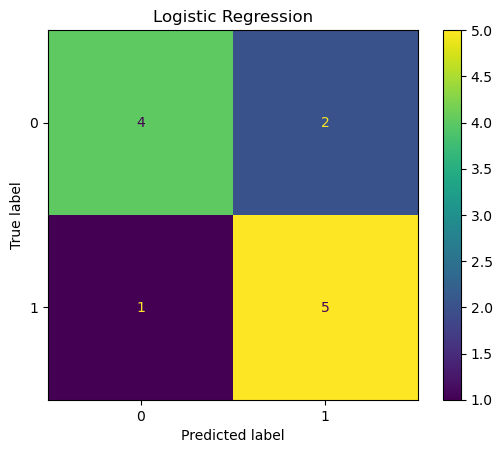

In [15]:
# confusion matrix logistic regression
cm_log = confusion_matrix(y_test, y_pred_log, labels=best_model_log.classes_)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log,
                              display_labels=best_model_log.classes_)
tn_log, fp_log, fn_log, tp_log= confusion_matrix(y_test, y_pred_log).ravel()
disp_log.plot()
plt.title("Logistic Regression")
plt.show()

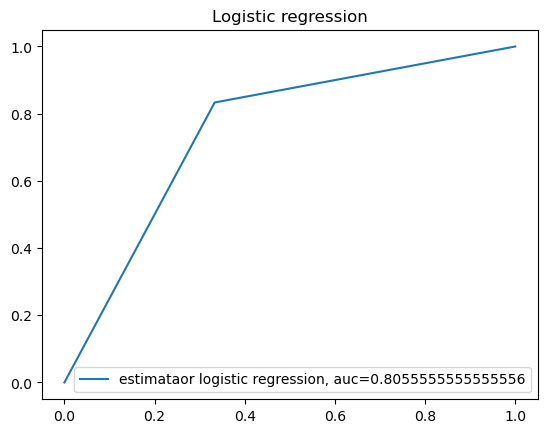

In [16]:
# ROC Logistic Regression
y_proba_log = best_model_log.predict_proba(X_test)[::,1]
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, y_pred_log)
auc_log = metrics.roc_auc_score(y_test, y_proba_log)
plt.plot(fpr_log,tpr_log,label="estimataor logistic regression, auc="+str(auc_log))
plt.legend(loc=4)
plt.title("Logistic regression")
plt.show()

In [17]:
#print(classification_report(y_test,  y_pred_log))

In [18]:
log_test_accuracy=round(accuracy_score(y_test, y_pred_log),2)
log_specifity=round(tn_log/(tn_log+fp_log),2)
log_recall=round(tp_log/(tp_log+fn_log),2)
log_precision=round(tp_log/(tp_log+fp_log),2)
log_f1score=round(2*(log_precision*log_recall)/(log_precision+log_recall),2)
log_auc = round(metrics.auc(fpr_log, tpr_log),2) # different 
log_list= ["logistic regression",log_test_accuracy,log_specifity,log_recall,log_precision, log_f1score, log_auc]
#log_list

In [19]:
# Classifier 2: decision tree
warnings.filterwarnings('ignore')
dt_comb = DecisionTreeClassifier(random_state = 42)
# gridsearch with crossvalidation
param_grid_dt = {'max_features': ['auto', 'sqrt','log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

grid_search_dt = GridSearchCV(estimator = dt_comb, param_grid = param_grid_dt, cv = kf, n_jobs = -1, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
best_model_dt = grid_search_dt.best_estimator_

print("Best: %f using %s" % (grid_search_dt.best_score_, grid_search_dt.best_params_))

Best: 0.683333 using {'ccp_alpha': 0.1, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'}


In [20]:
# Accuracy Decsion Trees
y_pred_dt = best_model_dt.predict(X_test)
print("Accuracy decision trees:",accuracy_score(y_test, y_pred_dt))

Accuracy decision trees: 0.4166666666666667


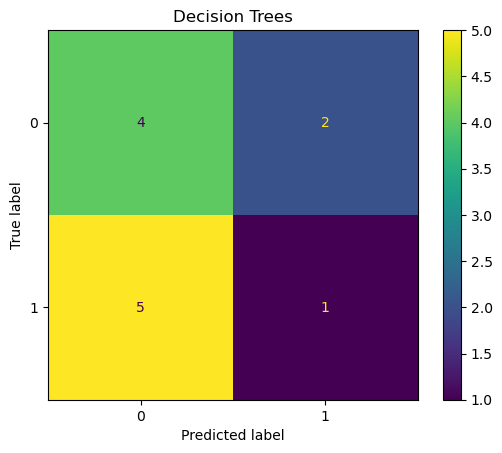

In [21]:
# confusion Matrix decision trees
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=best_model_dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                              display_labels=best_model_dt.classes_)
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, y_pred_dt).ravel()
disp_dt.plot()
plt.title("Decision Trees")
plt.show()

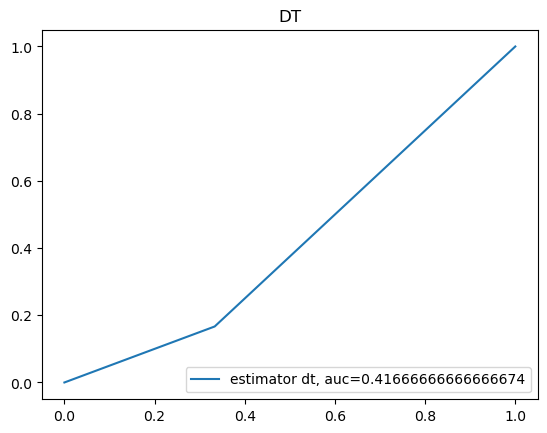

In [22]:
# ROC Decision Trees
y_proba_dt = best_model_dt.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, y_pred_dt)
auc_dt = metrics.roc_auc_score(y_test, y_proba_dt)
plt.plot(fpr_dt,tpr_dt,label="estimator dt, auc="+str(auc_dt))
plt.legend(loc=4)
plt.title("DT")
plt.show()

In [23]:
#print(classification_report(y_test,  y_pred_dt))

In [24]:
dt_test_accuracy=round(accuracy_score(y_test, y_pred_dt),2)
dt_specifity=round(tn_dt/(tn_dt+fp_dt),2)
dt_recall=round(tp_dt/(tp_dt+fn_dt),2)
dt_precision=round(tp_dt/(tp_dt+fp_dt),2)
dt_f1score=round(2*(dt_precision*dt_recall)/(dt_precision+dt_recall),2)
dt_auc = round(metrics.auc(fpr_dt, tpr_dt),2)
dt_list= ["decision tree",dt_test_accuracy,dt_specifity,dt_recall,dt_precision, dt_f1score, dt_auc]
#dt_list

In [25]:
# SVM
warnings.filterwarnings('ignore')
svm_com=svm.SVC()
# gridsearch with crossvalidation
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid', 'poly', 'linear']}  
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

grid_search_svm = GridSearchCV(estimator = svm_com, param_grid = param_grid_svm, cv = kf, n_jobs = -1, scoring = 'accuracy')
grid_search_svm.fit(X_train, y_train)
best_model_svm = grid_search_svm.best_estimator_

print("Best: %f using %s" % (grid_search_svm.best_score_, grid_search_svm.best_params_))
  

Best: 0.850000 using {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [26]:
# Accuracy
y_pred_svm = best_model_svm.predict(X_test)
print("Accuracy SVM:",accuracy_score(y_test, y_pred_svm))

Accuracy SVM: 0.75


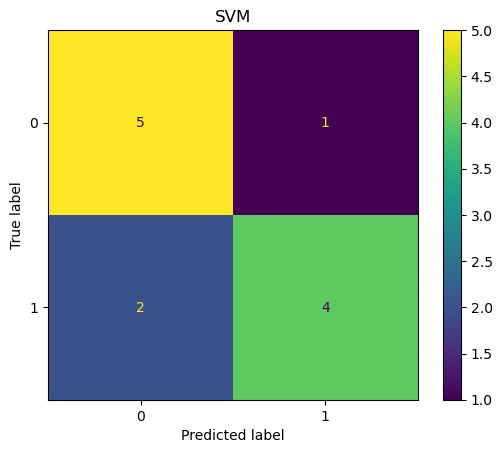

In [28]:
# SVN Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=best_model_svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                              display_labels=best_model_svm.classes_)
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_test, y_pred_svm).ravel()
disp_svm.plot()
plt.title("SVM")
plt.show()

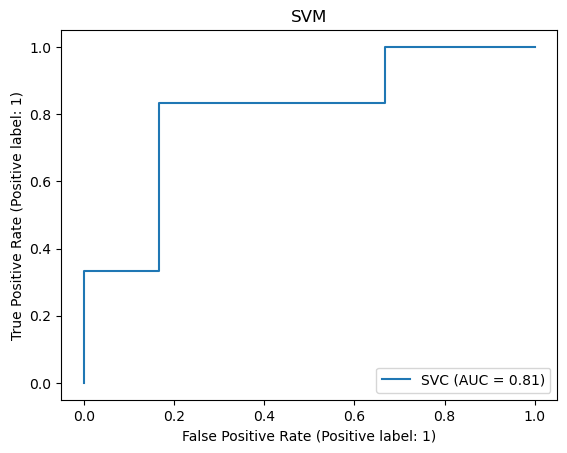

In [29]:
# ROC SVM
svc_disp = RocCurveDisplay.from_estimator(best_model_svm, X_test, y_test)
plt.title("SVM")
plt.show()

In [31]:
# Sensitivity SVM
svm_test_accuracy=round(accuracy_score(y_test, y_pred_svm),2)
svm_specifity=round(tn_svm / (tn_svm+fp_svm),2)
svm_recall=round(tp_svm / (tp_svm+fn_svm),2)
svm_precision=round(tp_svm / (tp_svm+fp_svm),2)
svm_f1score=round(2*(svm_precision*svm_recall)/(svm_precision+svm_recall),2)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_pred_svm)
svm_auc = round(metrics.auc(fpr_svm, tpr_svm),2)

svm_list= ["SVM",svm_test_accuracy,svm_specifity,svm_recall,svm_precision, svm_f1score, svm_auc]
#svm_list

In [32]:
estimators=[('Logistic Regression', best_model_log),
           ('Decision Tree', best_model_dt),
           ('SVM', best_model_svm)]

In [34]:
# stacking classifiers
SC = StackingClassifier(estimators=estimators,cv=5)
SC.fit(X_train, y_train)
y_pred_sc = SC.predict(X_test)

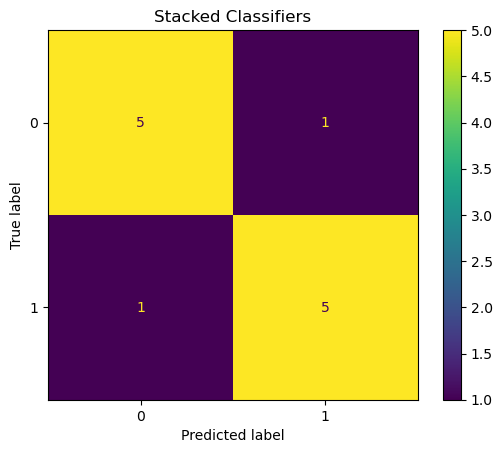

In [35]:
# confusion matrix stacked classifier
cm_sc = confusion_matrix(y_test, y_pred_sc, labels=SC.classes_)
tn_sc, fp_sc, fn_sc, tp_sc = confusion_matrix(y_test, y_pred_sc).ravel()
disp_sc = ConfusionMatrixDisplay(confusion_matrix=cm_sc,
                              display_labels=SC.classes_)
disp_sc.plot()
plt.title("Stacked Classifiers")
plt.show()

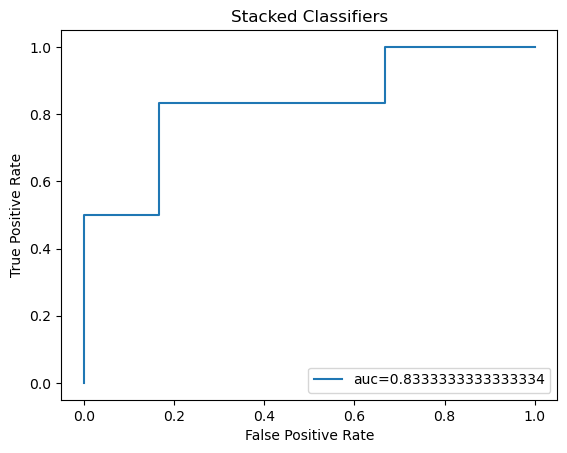

In [36]:
# ROC stacked classifier
y_proba_sc = SC.predict_proba(X_test)[::,1]
fpr_sc, tpr_sc, _ = metrics.roc_curve(y_test,  y_proba_sc)
auc_sc = metrics.roc_auc_score(y_test, y_proba_sc)
plt.plot(fpr_sc,tpr_sc,label="auc="+str(auc_sc))
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacked Classifiers")
plt.show()

In [37]:
y_pred_sc=SC.predict(X_test)
sc_test_accuracy=round(accuracy_score(y_test, y_pred_sc),2)
sc_specifity=round(tn_sc / (tn_sc+fp_sc),2)
sc_recall=round(tp_sc / (tp_sc+fn_sc),2)
sc_precision=round(tp_sc / (tp_sc+fp_sc),2)
sc_f1score=round(2*(sc_precision*sc_recall)/(sc_precision+sc_recall),2)
sc_auc = round(metrics.auc(fpr_sc, tpr_sc),2)
sc_list= ["stacked classifier",sc_test_accuracy,sc_specifity,sc_recall,sc_precision, sc_f1score, auc_sc]
#sc_list

In [38]:
# make table with metrics
#column names
cols= ["Classifier","Accuracy","Specifity","Recall","Precision","F1-score","AUC"]
# rows
list_classifiers = [log_list, dt_list,
         svm_list, sc_list]


In [39]:
results = pd.DataFrame(list_classifiers, columns=cols)
results

,Classifier,Accuracy,Specifity,Recall,Precision,F1-score,AUC
0,logistic regression,0.75,0.67,0.83,0.71,0.77,0.750000
1,decision tree,0.42,0.67,0.17,0.33,0.22,0.420000
2,SVM,0.75,0.83,0.67,0.80,0.73,0.750000
3,stacked classifier,0.83,0.83,0.83,0.83,0.83,0.833333
